### Step1 - 导入相关包 & 初始化设置

In [ ]:
import os, sys

from langchain.agents import create_agent
# ProviderStrategy: 需要模型原生支持, 效果最好, 但如果模型不支持则会报错
# ToolStrategy:     LangChain 会使用工具调用以实现相同的效果, 此方法适用于所有支持工具调用的模型
# AutoStrategy:     LangChain 会根据模型能力自动选择最佳策略
from langchain.agents.structured_output import ProviderStrategy, ToolStrategy, AutoStrategy
from langchain.chat_models import init_chat_model
# 常用的消息类型
from langchain.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage, AIMessageChunk

# 默读取当前目录下的 .env 文件, 可以通过 dotenv_path 来修改
from dotenv import load_dotenv
root_dir = os.path.dirname(os.getcwd())
load_dotenv(dotenv_path=os.path.join(root_dir, ".env"))

# 记录日志
from loguru import logger
logger.remove()
logger.add(sys.stderr, level=os.getenv("LOG_LEVEL"))

1

### Step2 - 定义结构化的数据类

In [ ]:
# 方法1: 使用 Pydantic 的 BaseModel
from pydantic import BaseModel, Field

class output_format_fun1(BaseModel):
    """
    自定义的输出格式
    """
    response_text: str = Field(description="回答内容")
    response_eval: int = Field(description="确定值, 对回复内容的确定程度, 值越高代表约确定, 范围是0~10")


In [ ]:
# 方法2: 使用 Dataclass (Python3 内嵌)
from dataclasses import dataclass

@dataclass
class output_format_fun2:
    """
    自定义的输出格式
    """
    response_text: str  # 回答内容
    response_eval: int  # 确定值, 对回复内容的确定程度, 值越高代表约确定, 范围是0~10

In [ ]:
# 方法3: 使用 TypedDict
from typing_extensions import TypedDict

class output_format_fun3(TypedDict):
    """
    自定义的输出格式
    """
    response_text: str  # 回答内容
    response_eval: int  # 确定值, 对回复内容的确定程度, 值越高代表约确定, 范围是0~10

In [ ]:
# 方法4: 使用 JSON Schema
output_format_json = {
    "type": "object",
    "description": "自定义的输出格式",
    "properties": {
        "response_text": {"type": "string", "description": "回答内容"},
        "response_eval": {"type": "int",    "description": "确定值, 对回复内容的确定程度, 值越高代表约确定, 范围是0~10"},
        "user_eval":    {"type": "string", "description": "对 user 的评估"},
    },
    "required": ["response_text", "response_eval"]
}

### Step3 - 创建 Agent 智能体

In [6]:
# 创建 ChatModel: v1 创建聊天模型的方法
chat_model = init_chat_model(
    model_provider="ollama",
    # model 也可以写为 <model_provider>:<model_name> 的形式
    # 这样就可以不用指定 model_provider 这个参数了
    model = os.getenv("OLLAMA_LLM_MODEL"),
    base_url = os.getenv("OLLAMA_BASE_URL"),
    max_tokens = 1024,
)
chat_model

ChatOllama(model='qwen3:4b-instruct', base_url='http://localhost:11434')

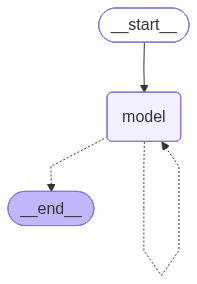

In [ ]:
# 创建 Agent
agent = create_agent(
    model=chat_model,
    # 提示词可以不写
    system_prompt="你是一个专业的AI助手, 请用简洁的方式回复用户的问题.",
    # 结构化输出: XXX_Strategy(<数据结构>)
    # ProviderStrategy/ToolStrategy/AutoStrategy 任选一个
    # 数据结构也是任选一个即可
    response_format=AutoStrategy(output_format_fun1),
)
agent

### Step4 - 调用智能体

In [ ]:
# 方法1: 非流式调用
# 也可以按照如下格式来写: {"messages":[{"role": "user", "content": "请简单介绍一下你自己."}]}
try:
    response = agent.invoke({"messages":[HumanMessage("请简单介绍一下你自己.")]})
except Exception as e:
    # 格式化输出可能会报错, 因此这里需要处理异常情况
    logger.error(e)
logger.debug(response)

for msg in response["messages"]:
    msg.pretty_print()

2025-12-05 23:23:23.463 | DEBUG    | __main__:<module>:8 - {'messages': [HumanMessage(content='请简单介绍一下你自己.', additional_kwargs={}, response_metadata={}, id='24dffd5c-0e41-4ab0-9da6-757dda794aa2'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:4b-instruct', 'created_at': '2025-12-05T15:23:23.4611375Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5534596000, 'load_duration': 4387308900, 'prompt_eval_count': 209, 'prompt_eval_duration': 60724300, 'eval_count': 78, 'eval_duration': 1004444200, 'logprobs': None, 'model_name': 'qwen3:4b-instruct', 'model_provider': 'ollama'}, id='lc_run--806246f9-5656-439c-9cb4-3b42cc247554-0', tool_calls=[{'name': 'output_format_fun1', 'args': {'respone_eval': 10, 'respone_text': '你好！我是一个AI助手，旨在帮助你解答问题、提供信息和完成各种任务。我可以根据你的需求提供简洁明了的回答，也可以协助你进行更复杂的思考和分析。有什么我可以帮你的吗？'}, 'id': 'b9f3d445-a186-4be1-bc4b-8056db9c8a35', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'output_tokens': 78, 'total_tokens': 287}), T

================================ Human Message =================================

请简单介绍一下你自己.
================================== Ai Message ==================================
Tool Calls:
  output_format_fun1 (b9f3d445-a186-4be1-bc4b-8056db9c8a35)
 Call ID: b9f3d445-a186-4be1-bc4b-8056db9c8a35
  Args:
    respone_eval: 10
    respone_text: 你好！我是一个AI助手，旨在帮助你解答问题、提供信息和完成各种任务。我可以根据你的需求提供简洁明了的回答，也可以协助你进行更复杂的思考和分析。有什么我可以帮你的吗？
================================= Tool Message =================================
Name: output_format_fun1

Returning structured response: respone_text='你好！我是一个AI助手，旨在帮助你解答问题、提供信息和完成各种任务。我可以根据你的需求提供简洁明了的回答，也可以协助你进行更复杂的思考和分析。有什么我可以帮你的吗？' respone_eval=10


In [9]:
# 方法2: 流式调用 & stream_mode 为 values
try:
    for chunk in agent.stream(({"messages":[HumanMessage("请简单介绍一下你自己.")]}), stream_mode="values"):
        chunk["messages"][-1].pretty_print()
except Exception as e:
    logger.error(e)

================================ Human Message =================================

请简单介绍一下你自己.
================================= Tool Message =================================
Name: output_format_fun1

Returning structured response: respone_text='你好！我是一个AI助手，旨在帮助你解答问题、提供信息和完成各种任务。我可以根据你的需求，提供简洁明了的回答，或者更深入的解释。无论你是想了解某个话题，还是需要帮助完成一项任务，我都会尽力为你服务！' respone_eval=10


In [14]:
# 方法3: 流式调用 & stream_mode 为 messages
try:
    for chunk in agent.stream({"messages":[HumanMessage("请简单介绍一下你自己.")]}, stream_mode="messages"):
        print(chunk[0].content, end="|", flush=True)
except Exception as e:
    logger.error(e)

|||Returning structured response: respone_text='你好！我是一个AI助手，可以帮你回答问题、提供信息和完成各种任务。无论你是需要知识查询、创意构思，还是简单的对话，我都会尽力为你提供帮助。' respone_eval=10|